# Calculating Tr$\left(\rho^{2}\right)$ from VQE data

In this notebook, we will take quantum circuits built via VQE, and append them to the overlap quantum circuits. 

In [6]:
from sys import path
path.insert(0, '..')
path.insert(0, '../../vqe')

from bba import *
from swap import *
from utilities import *
import numpy as np
import matplotlib.pyplot as plt
import pickle
import variational_form as vf
from qiskit.quantum_info import partial_trace,entropy

The pickled data files contain lists of quantum circuit configurations, with each element describing a disorder configuration. Below is a function that takes in parameters describing the system, and returns a list of quantum circuits.

In [7]:
def load_data(dir_name, W, num_qubits, entanglement, reps):
    fname="{}W{}_q{}_VVQE_SLSQP_{}_rep{}.pkl".format(dir_name, W, num_qubits, entanglement, reps)
    with open(fname,'rb') as f:
        vqe_list = pickle.load(f)
        qc_list = [None]*len(vqe_list)
        for i, vqe in enumerate(vqe_list):
            ansatz = vf.sz_conserved_ansatz(num_qubits, entanglement=entanglement, reps=reps)
            params = sorted(ansatz.parameters, key=lambda p: p.name) 
            params = dict(zip(params, vqe['opt_params'])) 
            qc_list[i] = ansatz.assign_parameters(params)
    return qc_list

Now let's load in some data for $n=4$ qubits, and $W$ ranging from 1 to 8.

In [8]:
num_qubits = 8
qc_dict = {}
W_list = list(range(1,9))
for W in W_list:
    print("W={}".format(W))
    qc_dict[W] = load_data("../../vqe/results/", W, num_qubits, 'sca', 2)

W=1
W=2
W=3
W=4
W=5
W=6
W=7
W=8


Now we connect this circuit to our overlap implementations and collect the second renyi entropys for all disorder and W.

In [9]:
import time
def run_vqe_overlap(qc_dict, overlap_func, shots=1000, noise=False):
    ent_dict = {}
    for W in qc_dict.keys():
        print("W={}".format(W))
        qc_list = qc_dict[W]
        o_list = [0]*len(qc_list)
        for i in range(len(qc_list)):
            print("     {}".format(i))
            psi = qc_list[i]
            n = psi.num_qubits//2
            s = time.time()
            overlap = overlap_func(psi, psi, list(range(n)), shots=shots, backend="qasm_simulator", noise=noise)
            e = time.time()
            print("time: {}".format(e - s))
            o_list.append(-np.log2(overlap))
        ent_dict[W] = o_list
    return ent_dict

In [ ]:
sw_ent_dict = run_vqe_overlap(qc_dict, bba_overlap, shots=1000, noise=True)

W=1
     0
time: 171.73023176193237
     1
time: 176.12503910064697
     2


In [18]:
def get_exact_entropies(qc_dict):

    backend = Aer.get_backend("statevector_simulator")
    ent_dict = {}
    for W in qc_dict.keys():
        print("W={}".format(W))
        qc_list = qc_dict[W]
        o_list = [0]*len(qc_list)
        for i in range(len(qc_list)):
            n = qc_list[i].num_qubits//2
            job = execute(qc_list[i], backend)
            vec = job.result().get_statevector(qc_list[i])
            rho = partial_trace(vec,range(n))
            ent = -np.log2((rho.data@rho.data).trace().real)
            o_list.append(ent)
        ent_dict[W] = o_list
    return ent_dict

In [19]:
exact_ent_dict = get_exact_entropies(qc_dict)

W=1
W=2
W=3
W=4
W=5
W=6
W=7
W=8


In [26]:
print(len(qc_dict[1]))

200


<IPython.core.display.Javascript object>


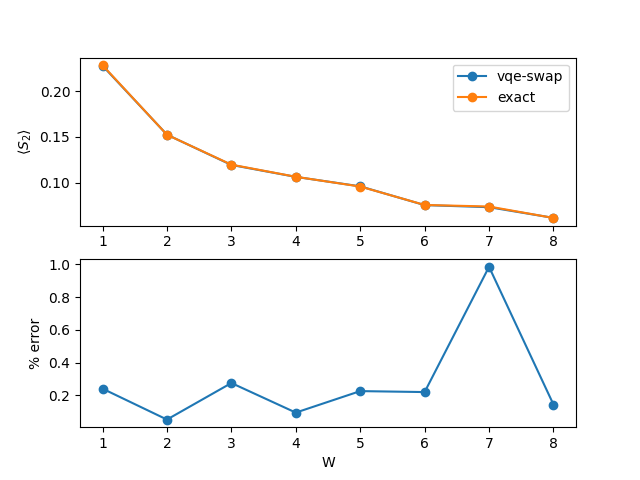

In [30]:

avg_o_list = [np.mean(sw_ent_dict[W]) for W in sw_ent_dict.keys()]
avg_oe_list = [np.mean(exact_ent_dict[W]) for W in exact_ent_dict.keys()]

%matplotlib notebook
#avg_oe_list = [0.5607389420956445, 0.7044439878950863, 0.7887799317531338, 0.8388761771782886, 0.870322646265184, 0.8920924456518833, 0.9082563943417088, 0.9204409755508297]
error_list = [np.abs((a - b)/b)*100 for (a,b) in zip(avg_o_list, avg_oe_list)]
plt.subplot(211)
plt.plot(list(range(1,9)), avg_o_list, 'o-', label='vqe-swap')
plt.plot(list(range(1,9)), avg_oe_list, 'o-', label='exact')
plt.ylabel(r"$\left<S_{2}\right>$")
plt.legend(loc='best')
plt.subplot(212)
plt.plot(list(range(1,9)), error_list, 'o-')
plt.ylabel("% error")
plt.xlabel("W")
plt.show()

In [24]:
print(np.mean(exact_ent_dict[1]))

0.22848544503847237


In [49]:
error_list = []
for i in range(1000):
    psi = qc_list[i]
    overlap = swap_overlap(psi, psi, [0,1], shots=100000, backend="qasm_simulator")
    backend = Aer.get_backend("statevector_simulator")
    job = execute(qc_list[i],backend)
    res = job.result()
    vec = res.get_statevector(qc_list[i])
    num_qubits=4
    rho = partial_trace(vec,range(num_qubits//2))
    S = entropy(rho)
    S2 = (rho.data@rho.data).trace().real
    error_list.append(np.abs(S2 - overlap))
plt.plot(list(range(1000)), error_list)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


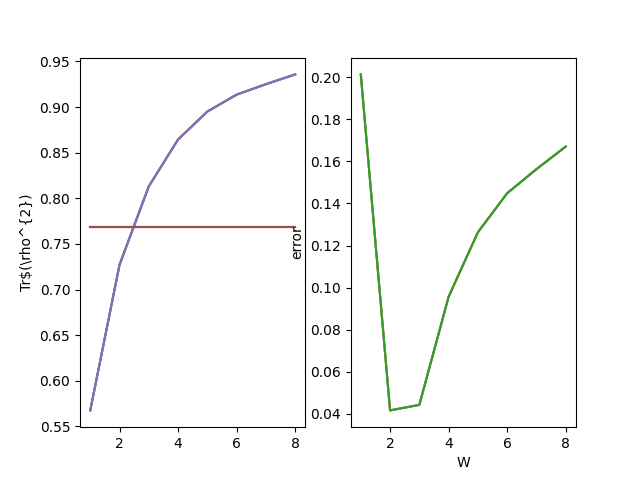

In [52]:
%matplotlib notebook
plt.plot(error_list)
plt.show()